# Lesson 04

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
import pandas as pd

In [2]:
pjme_url = 'https://d2xzmw6cctk25h.cloudfront.net/asset/1628958/attachment/f636d52dc446c950e31715ee269292eb.csv'

In [3]:
df = pd.read_csv(pjme_url, index_col=['Date'], parse_dates=['Date', 'Time'])

In [4]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,2020-01-28 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,2020-01-28 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,2020-01-28 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,2020-01-28 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,2020-01-28 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
df_w = df.resample('W').mean()

### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
h=4

Удалим данные о часах и днях, т.к. они потеряли актуальность

In [9]:
df_w.drop(['dayofmonth', 'dayofweek', 'dayofyear', 'dayofyear', 'hour'], axis=1, inplace=True)

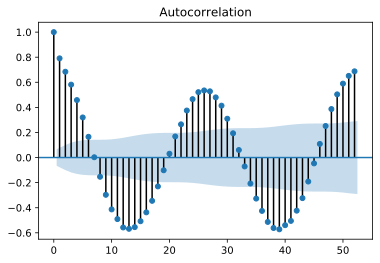

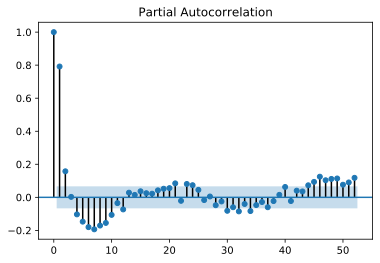

In [10]:
sm.graphics.tsa.plot_acf(df_w.PJME_MW.values, lags=52)
plt.show()
sm.graphics.tsa.plot_pacf(df_w.PJME_MW.values, lags=52)
plt.show()

In [11]:
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [12]:
data_split='01-06-2016'

#### Features engineering

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [14]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = df_w.values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

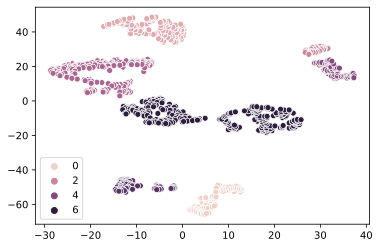

In [15]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

In [16]:
df_w['week_month'] = X_clast

In [17]:
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [18]:
df_w['pca1']=Xpca[:,0]
df_w['pca2']=Xpca[:,1]

In [19]:
df_w['diff1'] = df_w.PJME_MW.diff(periods=1)

In [20]:
df_w['d_w26']=df_w.PJME_MW.rolling(window=26).mean()

In [21]:
df_w['exp_0_05'] = exponential_smoothing(df_w.PJME_MW, 0.05)

In [22]:
df_w['diff1_l'] = np.log(df_w.PJME_MW)

In [23]:
p=4

for i in range(p):
    df_w[f't{str(p-i)}']=0
    df_w[f'd{str(p-i)}']=0
    
    df_w[f't{str(p-i)}'].values[p:] = df_w.PJME_MW.values[i:-(p)+i]
    df_w[f'd{str(p-i)}'].values[p:] = df_w.diff1.values[i:-(p)+i]

In [24]:
df_w.fillna(0, inplace=True)

#### Выделение существенных признаков

In [25]:
scl_target=StandardScaler() 

target = df_w.PJME_MW.values[h+p:].reshape((df_w.shape[0]-h-p,1))

y = scl_target.fit_transform(target)

y.shape

(858, 1)

In [26]:
scl_x=StandardScaler() 

X = df_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(858, 23)

In [27]:
np.nan_to_num(X, copy=False);

In [28]:
f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.98,  I=0
F-test=0.04,  I=1
F-test=0.02,  I=2
F-test=0.03,  I=3
F-test=0.02,  I=4
F-test=0.07,  I=5
F-test=0.06,  I=6
F-test=0.07,  I=7
F-test=0.08,  I=8
F-test=0.05,  I=9
F-test=0.05,  I=10
F-test=0.18,  I=11
F-test=0.01,  I=12
F-test=0.13,  I=13
F-test=1.00,  I=14
F-test=0.09,  I=15
F-test=0.00,  I=16
F-test=0.00,  I=17
F-test=0.23,  I=18
F-test=0.10,  I=19
F-test=0.25,  I=20
F-test=0.42,  I=21
F-test=0.22,  I=22


In [29]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(858, 5)

In [30]:
column_names = df_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd3', 'd2', 't1'], dtype='object')

In [31]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(858, 3)

In [32]:
column_namesp = df_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 't1'], dtype='object')

In [33]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(858, 5)

In [34]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 14 18 20 21]
Номера признаков лучших признаков по процентной форме:  [ 0 14 21]
Номера признаков для выбора по модели :  [ 0  4  9 14 15]


In [35]:
list_par = list(
                set(list_param_k) \
                .union(list_param_p) \
                .union(list_param_m)
    )

list_par.sort()
print(list_par)

[0, 4, 9, 14, 15, 18, 20, 21]


In [36]:
X_new = X[:,list_par]
df_w.columns[list_par]

Index(['PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 't4', 'd3', 'd2', 't1'], dtype='object')

#### Разделение данных на тестовые и тренировочные 

In [37]:
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [38]:
train, test = split_data(df_w.iloc[:,list_par], data_split)

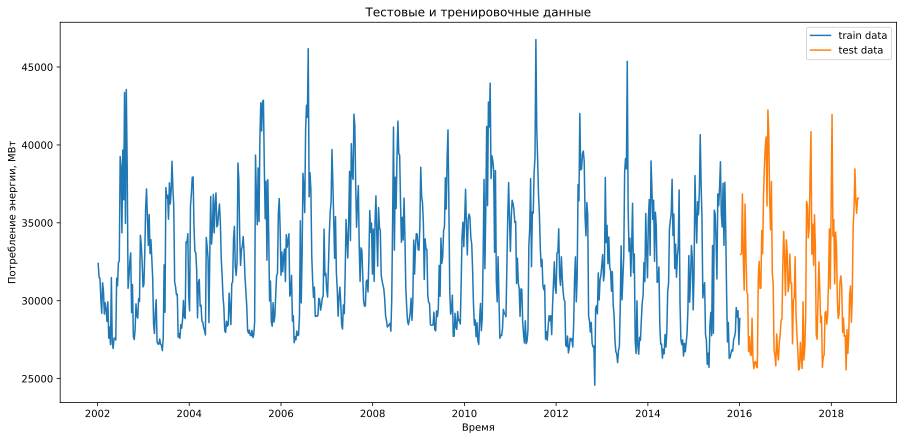

In [39]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index,train.PJME_MW, label='train data' )
plt.plot(test.index,test.PJME_MW, label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

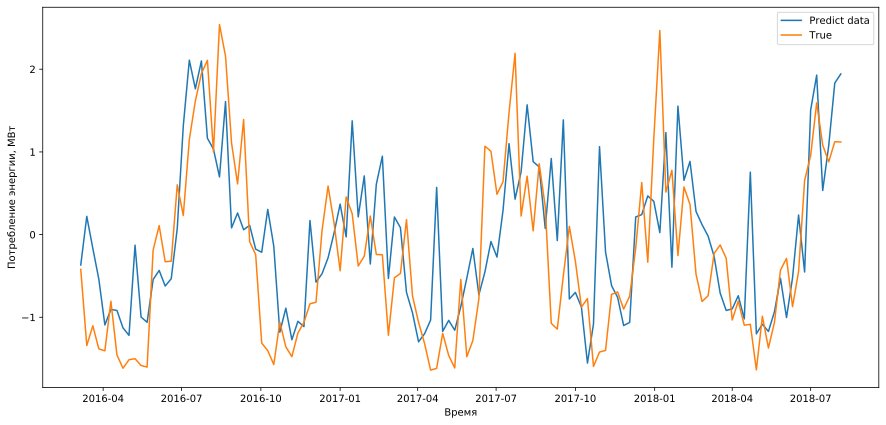

In [40]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

model = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model.fit(X_train, y_train)

y_pred_h4 = model.predict(X_test)

plt.figure(figsize=(15,7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_pred_h4, label='Predict data' )
plt.plot(test.index[h+p:],y_test, label='True')

plt.legend()
plt.show()

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
er_g_h4 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),y_pred = scl_target.inverse_transform(y_pred_h4))

print('ошибка градиентного бустинга MAPE :  ', er_g_h4,'%')

ошибка градиентного бустинга MAPE :   8.63414713083473 %


### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [43]:
scl_target=StandardScaler() 

h=1
target = df_w.PJME_MW.values[h+p:].reshape((df_w.shape[0]-h-p,1))

y = scl_target.fit_transform(target)

In [44]:
scl_x=StandardScaler() 

X = df_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

In [45]:
np.nan_to_num(X, copy=False);

In [46]:
X_new = X[:,list_par]
df_w.columns[list_par]

Index(['PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 't4', 'd3', 'd2', 't1'], dtype='object')

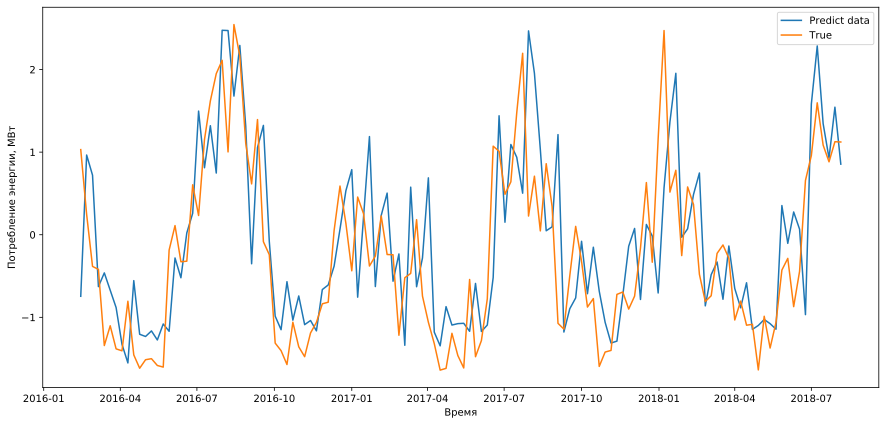

In [47]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

model_h1 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_h1.fit(X_train, y_train)

y_pred_h1 = model_h1.predict(X_test)

plt.figure(figsize=(15,7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_pred_h1, label='Predict data' )
plt.plot(test.index[h+p:],y_test, label='True')

plt.legend()
plt.show()

In [73]:
er_g_h1 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),y_pred = scl_target.inverse_transform(y_pred_h1))

print('ошибка градиентного бустинга MAPE :  ', er_g_h1,'%')

ошибка градиентного бустинга MAPE :   7.650200326342479 %


### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

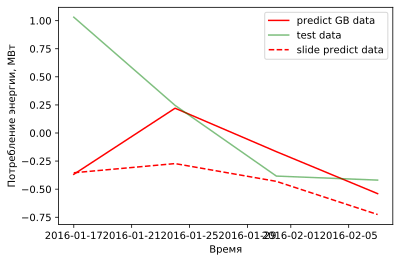

In [79]:
h_step=4

X_test_forward = X_test.copy()
y_test_forward = y_pred_h4.copy()

for i in range(h_step):
    y_test_forward[i] = model.predict(X_test_forward[i,:].reshape((1,X_test_forward.shape[1])))
    y_i=scl_target.inverse_transform(y_test_forward[i:i+1])
    
    X_test_forward[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    
    xy_i=(np.log((y_i))-scl_x.mean_[14])*scl_x.scale_[14]
    X_test_forward[i+1,3] = xy_i 


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:h_step+1],y_pred_h4[:h_step], 'r',label='predict GB data' )
plt.plot(test.index[1:h_step+1],y_test[:h_step], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:h_step+1],y_test_forward[:h_step], '--r',label='slide predict data')

plt.legend()
plt.show()      

In [80]:
er_g_r = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[:h_step]),y_pred=scl_target.inverse_transform(y_test_forward[:h_step]))
print('ошибка градиентного бустинга MAPE :  ', er_g_r,'%')

ошибка градиентного бустинга MAPE :   6.535485354623262 %


### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

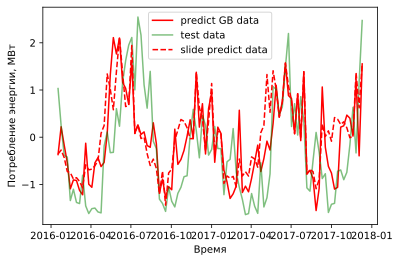

In [81]:
h_step=100

X_test_forward = X_test.copy()
y_test_forward = y_pred_h4.copy()

for i in range(h_step):
    y_test_forward[i] = model.predict(X_test_forward[i,:].reshape((1,X_test_forward.shape[1])))
    y_i=scl_target.inverse_transform(y_test_forward[i:i+1])
    
    X_test_forward[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    
    xy_i=(np.log((y_i))-scl_x.mean_[14])*scl_x.scale_[14]
    X_test_forward[i+1,3] = xy_i 


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:h_step+1],y_pred_h4[:h_step], 'r',label='predict GB data' )
plt.plot(test.index[1:h_step+1],y_test[:h_step], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:h_step+1],y_test_forward[:h_step], '--r',label='slide predict data')

plt.legend()
plt.show()      

### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Ошибка прогноза постепенно растет с увеличением количества моментов времени.